# Airbnb data challenge: business metric deviations

Using the Python data analytics packages to analyze when bookings fall out of typical rolling-average quantities. Includes a dataset of bookings over time.

#### Dataset sources:
GitHub  
Airbnb

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Data preprocessing and initial plotting 
Using Seaborn to visualize our time-series data and convert values as necessary.

In [2]:
# preparing plotting platform in seaborn
def reset_seaborn():
    sns.set()
    sns.set_style('white')
    sns.set_style('ticks')
    sns.despine()
    rcParams['figure.figsize'] = (7.5, 5)
#     sns.set_context('talk')
reset_seaborn()

In [3]:
# color palette
color8 = sns.hls_palette(8)

In [4]:
# import data
data = pd.read_csv('airbnb_data.csv')
data.rename(mapper = {'ds': 'date'}, axis = 1,inplace = True)
data.info() # we can see here that the dates are not yet in datetime formats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 3 columns):
city        729 non-null object
date        729 non-null object
bookings    729 non-null int64
dtypes: int64(1), object(2)
memory usage: 17.2+ KB


In [5]:
# convert date to datetime and sort in reverse order
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
city1 = data[data.city == 'City_1']
city2 = data[data.city == 'City_2']

city1.set_index(keys = ['date'], drop = True, inplace = True)
city2.set_index(keys = ['date'], drop = True, inplace = True)

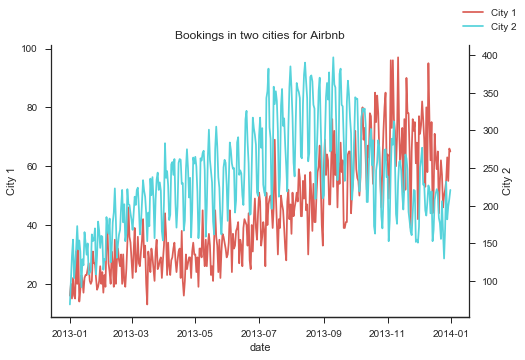

In [6]:
# let's examine the data visually
def doubleplot(y1, y1label, y2, y2label, title):
    sns.set_palette("husl")
    fig, ax1 = plt.subplots()
    ax1.plot(y1, c = color8[0], label = y1label)
    ax1.set(xlabel = 'date', ylabel = y1label)
    ax2 = ax1.twinx()
    ax2.plot(y2, c = color8[4], label = y2label)
    ax2.set(ylabel = y2label)
    sns.despine(ax = ax1, right = True, left = False)
    sns.despine(ax = ax2, left = True, right = False)
    fig.legend()
    plt.title(title)

doubleplot(city1.bookings, 'City 1', city2.bookings, 'City 2', \
          'Bookings in two cities for Airbnb')

### Adding in missing data
First we have to fix our missing city 2 data point.

In [7]:
# we are missing a value for City_2 that has to be filled in
print('Length of City_1: {}'.format(len(city1)))
print('Length of City_2: {}'.format(len(city2)))

# the date is June 24th on City_2
city1[~city1.index.isin(city2.index)]

Length of City_1: 365
Length of City_2: 364


,city,bookings
date,,
2013-06-24,City_1,40


In [8]:
# find the range of dates +/- 1 week (and 1 day extra)
city2['2013-06-16':'2013-07-02'].T

date,2013-06-16 00:00:00,2013-06-17 00:00:00,2013-06-18 00:00:00,2013-06-19 00:00:00,2013-06-20 00:00:00,2013-06-21 00:00:00,2013-06-22 00:00:00,2013-06-23 00:00:00,2013-06-25 00:00:00,2013-06-26 00:00:00,2013-06-27 00:00:00,2013-06-28 00:00:00,2013-06-29 00:00:00,2013-06-30 00:00:00,2013-07-01 00:00:00,2013-07-02 00:00:00
city,City_2,City_2,City_2,City_2,City_2,City_2,City_2,City_2,City_2,City_2,City_2,City_2,City_2,City_2,City_2,City_2
bookings,201,245,315,326,285,256,188,189,317,303,294,281,218,213,293,317


(array([735036., 735038., 735040., 735042., 735044., 735046., 735048.,
        735050.]), <a list of 8 Text xticklabel objects>)

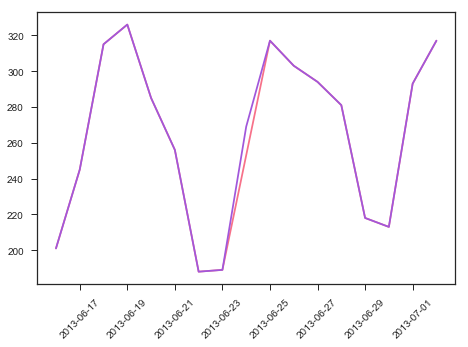

In [9]:
# plot this data to see trends
plt.plot(city2['2013-06-16':'2013-07-02'].bookings)
plt.xticks(rotation = 45)

# we can see a one-week cyclicality within the data on average
# as a result, we can fill in our missing value with the previous and after day of the same week
city2_missing = pd.DataFrame([{'date': datetime.strptime('2013-06-24', '%Y-%m-%d'), \
           'city': 'City_2', \
           'bookings': (city2.ix['2013-06-17', 'bookings'] + city2.ix['2013-07-01', 'bookings'])/2}])
city2_missing.set_index(keys = ['date'], drop = True, inplace = True)
city2 = city2.append(city2_missing, sort = True)
city2.sort_index(inplace = True)

# re-plot this data to see trends and slight impact of the fix
# frankly, we could have just averaged the day before/after, but it's less intuitive of an explanation
plt.plot(city2['2013-06-16':'2013-07-02'].bookings, c = color8[6])
plt.xticks(rotation = 45)

### Visualization and examination
The data is evidently non-stationary, which we will look into and examine from several perspectives. We can determine there is an overall increasing trend from our direct plots and boxplots, verify it statistically is non-stationary with an ADF test, but more importantly look at existing rolling mean/std graphs to show we are still not accounting for weekends/other fluctuations. Let's first look at just `City_1` data before repeating it for `City_2`.

In [10]:
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller
from pylab import * 

In [11]:
# drop city label from both 
city1.drop(labels = ['city'], axis = 1, inplace = True)
city2.drop(labels = ['city'], axis = 1, inplace = True)
city1.T.head()

date,2013-01-01 00:00:00,2013-01-02 00:00:00,2013-01-03 00:00:00,2013-01-04 00:00:00,2013-01-05 00:00:00,2013-01-06 00:00:00,2013-01-07 00:00:00,2013-01-08 00:00:00,2013-01-09 00:00:00,2013-01-10 00:00:00,...,2013-12-22 00:00:00,2013-12-23 00:00:00,2013-12-24 00:00:00,2013-12-25 00:00:00,2013-12-26 00:00:00,2013-12-27 00:00:00,2013-12-28 00:00:00,2013-12-29 00:00:00,2013-12-30 00:00:00,2013-12-31 00:00:00
bookings,16,20,15,22,16,15,31,20,32,14,...,62,57,46,50,52,55,63,55,66,65


Text(0.5,1,'City 1')

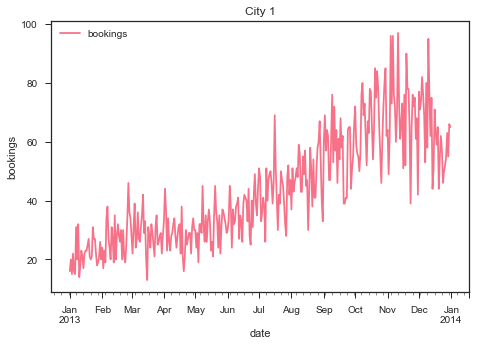

In [12]:
# view the data
city1.plot()
plt.ylabel('bookings')
plt.title('City 1')

Text(0.5,1,'Boxplot of bookings in each month, City 1')

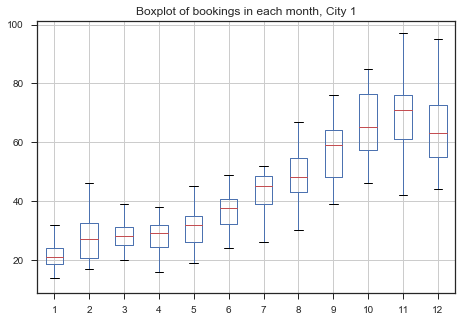

In [13]:
# group by month and view boxplots - evidently non-stationary
reset_seaborn()
city1_groups = city1.groupby(pd.Grouper(freq='M'))
city1_monthly = pd.concat([x[1] for x in city1_groups], axis = 1)
month_cols = [x for x in range(1, 13)]
city1_monthly.columns = month_cols

city1_monthly.boxplot()
plt.title('Boxplot of bookings in each month, City 1')

In [14]:
# statistical ADF test for non-stationarity - we'd assume to reject null hypothesis
city1_ADF = adfuller(city1.bookings, maxlag = 30, regression = 'ct', autolag = 'BIC')
print('Augmented Dickey-Fuller test with BIC for number of lags')
print('test statistic: {}'.format(city1_ADF[0]))
print('number of lags: {}'.format(city1_ADF[2])) 
print('p-value: {}'.format(city1_ADF[1]))

Augmented Dickey-Fuller test with BIC for number of lags
test statistic: -2.816950362560654
number of lags: 6
p-value: 0.19078843441984472


The statistical test fails to reject the null hypothesis, indicating this data is non-stationary. We must remove the trends; here, we do not have a seasonality effect to worry about/be able to deal with as it's only one year of data.

However, before we do that, we can quickly look at the existing graphs for rolling mean and standard deviation. Below, we will plot these with color ranges, and we can quickly see how despite the trends in the data, perhaps one issue we might see is a relatively consistent fluctuation out of this zone - the periodicity of this appears to be potentially weekly or biweekly, so it could be something to examine.

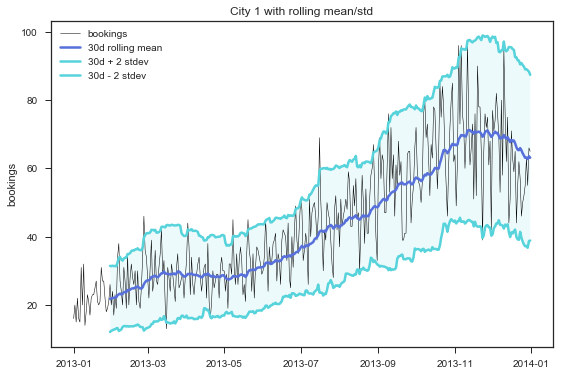

In [15]:
# 30 day rolling mean
city1_rolling_mean = city1.rolling(30).mean()
city1_rolling_std = city1.rolling(30).std()
city1_std_above = (city1_rolling_mean + city1_rolling_std*2).bookings
city1_std_below = (city1_rolling_mean - city1_rolling_std*2).bookings

# plot with mean
plt.figure(figsize = (9, 6))
plt.plot(city1, c = 'black', label = 'bookings', linewidth = .5)
plt.plot(city1_rolling_mean, c = color8[5], label = '30d rolling mean', linewidth = 2.5)

# 2std rolling means fill area
plt.plot(city1_rolling_mean + city1_rolling_std*2, c = color8[4], label = '30d + 2 stdev', linewidth = 2.5)
plt.plot(city1_rolling_mean - city1_rolling_std*2, c = color8[4], label = '30d - 2 stdev', linewidth = 2.5)
plt.fill_between(city1.index, city1_std_above, city1_std_below, facecolor = color8[4], alpha = 0.1)

# plot semantics
plt.ylabel('bookings')
plt.legend()
plt.title('City 1 with rolling mean/std')
plt.show()

### Preliminary results
Based on this initial analysis, we can see the data is non-stationary which should be addressed. However, if we do an initial computation, then we would have about 27 days out of just short of 2 years where we had an alert triggered.

In [16]:
# counting number of violations
city1['alert'] = (city1.bookings > city1_std_above) | (city1.bookings < city1_std_below)

# city2
city2_rolling_mean = city2.rolling(30).mean()
city2_rolling_std = city2.rolling(30).std()
city2_std_above = (city2_rolling_mean + city2_rolling_std*2).bookings
city2_std_below = (city2_rolling_mean - city2_rolling_std*2).bookings
city2['alert'] = (city2.bookings > city2_std_above) | (city2.bookings < city2_std_below)

# output
print('City 1 had {} days where an alert would have been triggered.'.format(sum(city1.alert)))
print('City 2 had {} days where an alert would have been triggered.'.format(sum(city2.alert)))

City 1 had 19 days where an alert would have been triggered.
City 2 had 8 days where an alert would have been triggered.


### Removing trends in data
We see that the data is relatively non-stationary, with bookings in each city changing by the month. Moreover, there are fluctuations within the months (which appear to potentially be weekends) that have to be taken care of. This is our first priority since it appears to be the biggest source of fluctuations.

In [17]:
# differencing the data - computing means
city1_means = mean(city1_monthly)
city1_means

1     21.709677
2     27.392857
3     28.290323
4     28.700000
5     30.967742
6     36.133333
7     43.322581
8     48.225806
9     56.933333
10    67.000000
11    69.200000
12    63.580645
dtype: float64

In [18]:
# removing averages
city1['month'] = city1.index.month
city1['month'] = city1['month'].apply(lambda x: city1_means[x])
city1['deavg'] = city1['bookings'] - city1['month']
city1.head(10)

,bookings,alert,month,deavg
date,,,,
2013-01-01,16,False,21.709677,-5.709677
2013-01-02,20,False,21.709677,-1.709677
2013-01-03,15,False,21.709677,-6.709677
2013-01-04,22,False,21.709677,0.290323
2013-01-05,16,False,21.709677,-5.709677
2013-01-06,15,False,21.709677,-6.709677
2013-01-07,31,False,21.709677,9.290323
2013-01-08,20,False,21.709677,-1.709677
2013-01-09,32,False,21.709677,10.290323


In [19]:
# removing averages
city2_groups = city2[['bookings']].groupby(pd.Grouper(freq='M'))
city2_monthly = pd.concat([x[1] for x in city2_groups], axis = 1)
city2_monthly.columns = [x for x in range(1, 13)]
city2_means = mean(city2_monthly)
city2['month'] = city2.index.month
city2['month'] = city2['month'].apply(lambda x: city2_means[x])
city2['deavg'] = city2['bookings'] - city2['month']
city2.head(10)

,bookings,alert,month,deavg
date,,,,
2013-01-01,69.0,False,136.935484,-67.935484
2013-01-02,101.0,False,136.935484,-35.935484
2013-01-03,134.0,False,136.935484,-2.935484
2013-01-04,155.0,False,136.935484,18.064516
2013-01-05,104.0,False,136.935484,-32.935484
2013-01-06,121.0,False,136.935484,-15.935484
2013-01-07,143.0,False,136.935484,6.064516
2013-01-08,173.0,False,136.935484,36.064516
2013-01-09,142.0,False,136.935484,5.064516


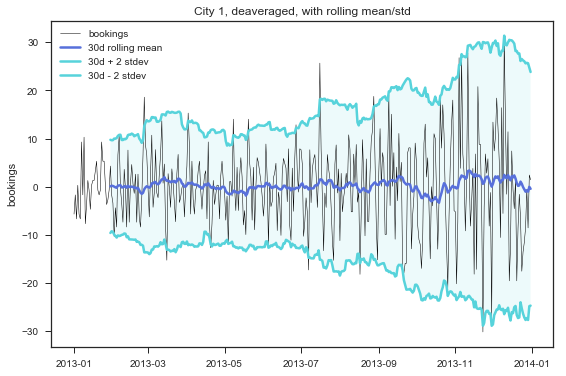

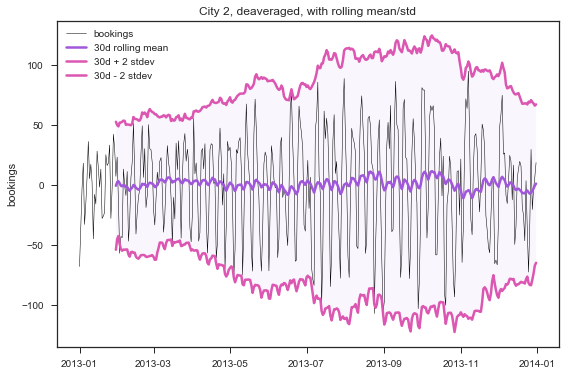

In [20]:
## City 1
# 30 day rolling mean
city1_rolling_mean = city1['deavg'].rolling(30).mean()
city1_rolling_std = city1['deavg'].rolling(30).std()
city1_std_above_final = (city1_rolling_mean + city1_rolling_std*2)
city1_std_below_final = (city1_rolling_mean - city1_rolling_std*2)

# plot with mean
plt.clf()
plt.figure(figsize = (9, 6))
plt.plot(city1['deavg'], c = 'black', label = 'bookings', linewidth = .5)
plt.plot(city1_rolling_mean, c = color8[5], label = '30d rolling mean', linewidth = 2.5)

# 2std rolling means fill area
plt.plot(city1_rolling_mean + city1_rolling_std*2, c = color8[4], label = '30d + 2 stdev', linewidth = 2.5)
plt.plot(city1_rolling_mean - city1_rolling_std*2, c = color8[4], label = '30d - 2 stdev', linewidth = 2.5)
plt.fill_between(city1.index, city1_std_above_final, city1_std_below_final, facecolor = color8[4], alpha = 0.1)

# plot semantics
plt.ylabel('bookings')
plt.legend()
plt.title('City 1, deaveraged, with rolling mean/std')

'''----------'''

## City 2
# 30 day rolling mean
city2_rolling_mean = city2['deavg'].rolling(30).mean()
city2_rolling_std = city2['deavg'].rolling(30).std()
city2_std_above_final = (city2_rolling_mean + city2_rolling_std*2)
city2_std_below_final = (city2_rolling_mean - city2_rolling_std*2)

# plot with mean
plt.figure(figsize = (9, 6))
plt.plot(city2['deavg'], c = 'black', label = 'bookings', linewidth = .5)
plt.plot(city2_rolling_mean, c = color8[6], label = '30d rolling mean', linewidth = 2.5)

# 2std rolling means fill area
plt.plot(city2_rolling_mean + city2_rolling_std*2, c = color8[7], label = '30d + 2 stdev', linewidth = 2.5)
plt.plot(city2_rolling_mean - city2_rolling_std*2, c = color8[7], label = '30d - 2 stdev', linewidth = 2.5)
plt.fill_between(city2.index, city2_std_above_final, city2_std_below_final, facecolor = color8[6], alpha = 0.05)

# plot semantics
plt.ylabel('bookings')
plt.legend()
plt.title('City 2, deaveraged, with rolling mean/std')
plt.show()

In [21]:
# counting number of violations - new standard below/above
city1['alert2'] = (city1.deavg > city1_std_above_final) | (city1.deavg < city1_std_below_final)
city2['alert2'] = (city2.deavg > city2_std_above_final) | (city2.deavg < city2_std_below_final)

# output
print('City 1 after deaveraging had {} days where an alert would have been triggered.'.format(sum(city1.alert2)))
print('City 2 after deaveraging had {} days where an alert would have been triggered.'.format(sum(city2.alert2)))

City 1 after deaveraging had 17 days where an alert would have been triggered.
City 2 after deaveraging had 2 days where an alert would have been triggered.


In [22]:
# statistical ADF test for non-stationarity - we'd assume to reject null hypothesis
city1_ADF = adfuller(city1.deavg, maxlag = 30, regression = 'ct', autolag = 'BIC')
print('Augmented Dickey-Fuller test with BIC for number of lags - City 1')
print('test statistic: {}'.format(city1_ADF[0]))
print('number of lags: {}'.format(city1_ADF[2])) 
print('p-value: {}'.format(city1_ADF[1]))

print('-----')

# statistical ADF test for non-stationarity - we'd assume to reject null hypothesis
city2_ADF = adfuller(city2.deavg, maxlag = 30, regression = 'ct', autolag = 'BIC')
print('Augmented Dickey-Fuller test with BIC for number of lags - City 2')
print('test statistic: {}'.format(city2_ADF[0]))
print('number of lags: {}'.format(city2_ADF[2])) 
print('p-value: {}'.format(city2_ADF[1]))

Augmented Dickey-Fuller test with BIC for number of lags - City 1
test statistic: -5.740815905866927
number of lags: 6
p-value: 7.5639706572573046e-06
-----
Augmented Dickey-Fuller test with BIC for number of lags - City 2
test statistic: -6.997354277974601
number of lags: 15
p-value: 1.4326123945904555e-08


### Moving on to weekly-level analysis
In this short analysis we've now reduced the number of exception days to 19 by deaveraging it on the month. As can be seen in the graphs and tests above, the deaveraged samples are stationary datasets. However, the dataset still appears very noisy with likely weekly bookings, which we have not taken out.

In [23]:
# determining weekdays
city1['weekday'] = city1.index.weekday
city1_weekly = city1.groupby('weekday')['bookings'].mean()

In [24]:
# evidently there are differences in the weekly data
city1_weekly

weekday
0    48.153846
1    47.849057
2    46.884615
3    43.538462
4    40.711538
5    34.846154
6    42.711538
Name: bookings, dtype: float64

In [25]:
# net difference from mean
city1_net = city1_weekly - mean(city1_weekly)
city1_net

weekday
0    4.625959
1    4.321169
2    3.356728
3    0.010574
4   -2.816349
5   -8.681733
6   -0.816349
Name: bookings, dtype: float64

In [26]:
# removing weekly bookings after deaveraging
city1['weekly_avg'] = city1['weekday'].apply(lambda i: city1_net[i])
city1['noweek'] = city1['bookings'] - city1['weekly_avg']
city1.head(20)

,bookings,alert,month,deavg,alert2,weekday,weekly_avg,noweek
date,,,,,,,,
2013-01-01,16,False,21.709677,-5.709677,False,1,4.321169,11.678831
2013-01-02,20,False,21.709677,-1.709677,False,2,3.356728,16.643272
2013-01-03,15,False,21.709677,-6.709677,False,3,0.010574,14.989426
2013-01-04,22,False,21.709677,0.290323,False,4,-2.816349,24.816349
2013-01-05,16,False,21.709677,-5.709677,False,5,-8.681733,24.681733
2013-01-06,15,False,21.709677,-6.709677,False,6,-0.816349,15.816349
2013-01-07,31,False,21.709677,9.290323,False,0,4.625959,26.374041
2013-01-08,20,False,21.709677,-1.709677,False,1,4.321169,15.678831
2013-01-09,32,False,21.709677,10.290323,False,2,3.356728,28.643272


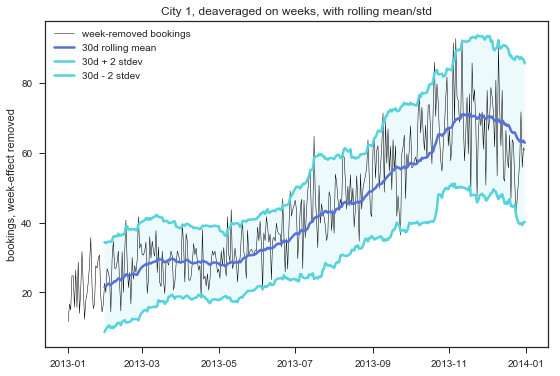

In [27]:
## City 1
# 30 day rolling mean
city1_rolling_mean = city1['noweek'].rolling(30).mean()
city1_rolling_std = city1['noweek'].rolling(30).std()
city1_std_above = (city1_rolling_mean + city1_rolling_std*2)
city1_std_below = (city1_rolling_mean - city1_rolling_std*2)

# plot with mean
plt.clf()
plt.figure(figsize = (9, 6))
plt.plot(city1['noweek'], c = 'black', label = 'week-removed bookings', linewidth = .5)
plt.plot(city1_rolling_mean, c = color8[5], label = '30d rolling mean', linewidth = 2.5)

# 2std rolling means fill area
plt.plot(city1_rolling_mean + city1_rolling_std*2, c = color8[4], label = '30d + 2 stdev', linewidth = 2.5)
plt.plot(city1_rolling_mean - city1_rolling_std*2, c = color8[4], label = '30d - 2 stdev', linewidth = 2.5)
plt.fill_between(city1.index, city1_std_above, city1_std_below, facecolor = color8[4], alpha = 0.1)

# plot semantics
plt.ylabel('bookings, week-effect removed')
plt.legend()
plt.title('City 1, deaveraged on weeks, with rolling mean/std')
plt.show()

In [28]:
# counting number of violations - new standard below/above
city1['alert3'] = (city1.noweek > city1_std_above) | (city1.noweek < city1_std_below)
# city2['alert3'] = (city2.noweek > city2_std_above) | (city2.noweek < city2_std_below)

# output
print('City 1 after deaveraging on weeks only had {} days where an alert would have been triggered.'.format(sum(city1.alert3)))
# print('City 2 after deaveraging on weeks as well had {} days where an alert would have been triggered.'.format(sum(city2.alert3)))

City 1 after deaveraging on weeks only had 19 days where an alert would have been triggered.


Evidently, looking at either alone doesn't really give us the best picture, so we should be subtracting both from our total. Let's subtract weekly removals and then remove the effects of months as well.

In [29]:
# removing averages
city1_groups = city1[['noweek']].groupby(pd.Grouper(freq='M'))
city1_monthly = pd.concat([x[1] for x in city1_groups], axis = 1)
city1_monthly.columns = [x for x in range(1, 13)]
city1_means = mean(city1_monthly)
city1['noweekmonth'] = city1.index.month
city1['noweekmonth'] = city1['noweekmonth'].apply(lambda x: city1_means[x])
city1['deavg2'] = city1['noweek'] - city1['noweekmonth']
city1.head(10)

,bookings,alert,month,deavg,alert2,weekday,weekly_avg,noweek,alert3,noweekmonth,deavg2
date,,,,,,,,,,,
2013-01-01,16,False,21.709677,-5.709677,False,1,4.321169,11.678831,False,21.461662,-9.782832
2013-01-02,20,False,21.709677,-1.709677,False,2,3.356728,16.643272,False,21.461662,-4.818390
2013-01-03,15,False,21.709677,-6.709677,False,3,0.010574,14.989426,False,21.461662,-6.472237
2013-01-04,22,False,21.709677,0.290323,False,4,-2.816349,24.816349,False,21.461662,3.354687
2013-01-05,16,False,21.709677,-5.709677,False,5,-8.681733,24.681733,False,21.461662,3.220071
2013-01-06,15,False,21.709677,-6.709677,False,6,-0.816349,15.816349,False,21.461662,-5.645313
2013-01-07,31,False,21.709677,9.290323,False,0,4.625959,26.374041,False,21.461662,4.912379
2013-01-08,20,False,21.709677,-1.709677,False,1,4.321169,15.678831,False,21.461662,-5.782832
2013-01-09,32,False,21.709677,10.290323,False,2,3.356728,28.643272,False,21.461662,7.181610


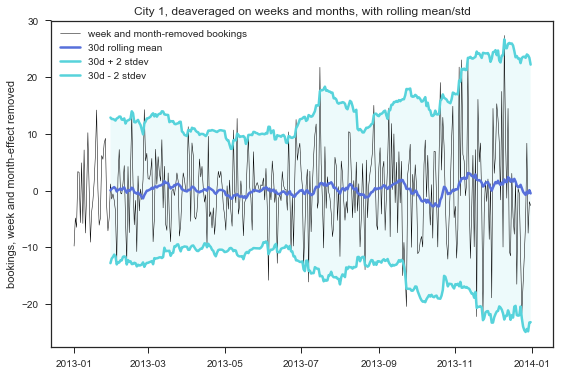

In [30]:
## City 1
# 30 day rolling mean
city1_rolling_mean = city1['deavg2'].rolling(30).mean()
city1_rolling_std = city1['deavg2'].rolling(30).std()
city1_std_above = (city1_rolling_mean + city1_rolling_std*2)
city1_std_below = (city1_rolling_mean - city1_rolling_std*2)

# plot with mean
plt.clf()
plt.figure(figsize = (9, 6))
plt.plot(city1['deavg2'], c = 'black', label = 'week and month-removed bookings', linewidth = .5)
plt.plot(city1_rolling_mean, c = color8[5], label = '30d rolling mean', linewidth = 2.5)

# 2std rolling means fill area
plt.plot(city1_rolling_mean + city1_rolling_std*2, c = color8[4], label = '30d + 2 stdev', linewidth = 2.5)
plt.plot(city1_rolling_mean - city1_rolling_std*2, c = color8[4], label = '30d - 2 stdev', linewidth = 2.5)
plt.fill_between(city1.index, city1_std_above, city1_std_below, facecolor = color8[4], alpha = 0.1)

# plot semantics
plt.ylabel('bookings, week and month-effect removed')
plt.legend()
plt.title('City 1, deaveraged on weeks and months, with rolling mean/std')
plt.show()

In [31]:
# counting number of violations - new standard below/above
city1['alert4'] = (city1.deavg2 > city1_std_above) | (city1.deavg2 < city1_std_below)
# city2['alert3'] = (city2.noweek > city2_std_above) | (city2.noweek < city2_std_below)

# output
print('City 1 after deaveraging on weeks and months had {} days where an alert would have been triggered.'.format(sum(city1.alert4)))
# print('City 2 after deaveraging on weeks as well had {} days where an alert would have been triggered.'.format(sum(city2.alert3)))

City 1 after deaveraging on weeks and months had 22 days where an alert would have been triggered.


It appears from above that deaveraging on weeks may just make things worse, although likely this could be attributed to my lack of familiarity working with time-series analysis.

In [32]:
# final output
# counting number of violations - new standard below/above
city1['alert2'] = (city1.deavg > city1_std_above_final) | (city1.deavg < city1_std_below_final)
city2['alert2'] = (city2.deavg > city2_std_above_final) | (city2.deavg < city2_std_below_final)

# output
print('City 1 after deaveraging had {} days where an alert would have been triggered.'.format(sum(city1.alert2)))
print('City 2 after deaveraging had {} days where an alert would have been triggered.'.format(sum(city2.alert2)))

City 1 after deaveraging had 17 days where an alert would have been triggered.
City 2 after deaveraging had 2 days where an alert would have been triggered.


### Conclusions
From above, we ended up having 17 days where the alert would have been triggered on City 1, and 2 for City 2. Throughout this analysis the following was accomplished:
- [x] Exploratory analysis
- [x] Checking for missing data points
- [x] Filling in missing data appropriately
- [x] Checking for non-stationarity/ADF test
- [x] Removing impact of month, making data stationary
- [x] Computing rolling means and standard deviations

Looking forward, some of the next steps that would have been nice to get done here are:
- [ ] Removing effects of weeks
- [ ] Cleaner visualizations

The former is probably the biggest part missing, although it's likely that the weekly removals were done incorrectly (please let me know if you have other suggestions!). The experience with working with the `ts` type data, between looking at indices and removing the non-stationarity, was generally valuable. 